In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, zpk2sos, sosfiltfilt
from scipy.fft import fft, fft2, fftshift
import warnings
import time

warnings.filterwarnings('ignore')

#%matplotlib tk
%matplotlib inline

In [3]:
'''
============================================================================
Read Dataset
============================================================================
'''
def read_h5_file(filePath):
    """Reads HDF5 file and extracts metadata and data."""
    print('Reading file metadata...')

    try:
        with h5py.File(filePath, 'r') as f:
            # Read metadata
            fs = f['/Acquisition'].attrs['PulseRate']
            dx = f['/Acquisition'].attrs['SpatialSamplingInterval']
            num_locs = f['/Acquisition'].attrs['NumberOfLoci']

            # Read main data
            X = f['/Acquisition/Raw[0]/RawData'][:]
            X = X.astype(np.float64)

        print('Metadata read successfully:')
        print(f' -> fs = {fs:.1f} Hz')
        print(f' -> dx = {dx:.3f} m')
        print(f' -> num_locs = {num_locs} channels')

        return X, fs, dx, num_locs

    except Exception as e:
        raise RuntimeError(f'Error reading the file: {str(e)}')

In [4]:
'''
============================================================================
TEMPORAL TRIMMING
============================================================================
'''
def temporal_cut(X, t, t_start_cut, t_end_cut):
    """Applies temporal cut to the data."""
    print('Applying temporal cut...')

    t_original_end = t[-1]
    num_tr_original = X.shape[1]

    # Find indices where t is between t_start_cut and t_end_cut
    condition = (t >= t_start_cut) & (t <= t_end_cut)
    valid_indices = np.where(condition)[0]

    if len(valid_indices) == 0:
        print(f"Error: No data in range {t_start_cut}s to {t_end_cut}s")
        return X, t

    idx_start = valid_indices[0]
    idx_end = valid_indices[-1]

    # Cut the data
    X_cut = X[:, idx_start:idx_end+1]
    t_cut = t[idx_start:idx_end+1]
    #num_s = X_cut.shape[0]
    num_locs_new, num_tr_new = X_cut.shape

    print('Temporal cut completed.')
    print(f' -> Original time: {t[0]:.2f} s to {t_original_end:.2f} s ({num_tr_original} samples)')
    print(f' -> New time:      {t_cut[0]:.2f} s to {t_cut[-1]:.2f} s ({num_tr_new} samples)')

    return X_cut, t_cut


In [5]:
'''
============================================================================
BAND-PASS FILTER
============================================================================
'''

def bandpass_filter(X, fs, hp_cut, lp_cut, order=4):
    """Applies a band-pass filter to each channel."""
    print(f'Applying band-pass filter from {hp_cut} to {lp_cut} Hz...')
    nyquist = fs / 2
    Wn = [hp_cut / nyquist, lp_cut / nyquist]
    sos = butter(order, Wn, btype='bandpass', output='sos')
    for channel_idx in range(X.shape[0]):  # channels
        X[channel_idx, :] = sosfiltfilt(sos, X[channel_idx, :])

    print('Filtering completed.')
    return X

In [6]:
'''
============================================================================
SPATIAL GROUPING (BINNING)
============================================================================
'''

def spatial_binning(X, y, N_group=3):
    """Spatially groups channels."""
    print('Starting spatial channel binning...')

    num_locs_real, num_tr = X.shape
    n_keep = (num_locs_real // N_group) * N_group

    if n_keep < N_group:
        raise ValueError(f'N_group={N_group} is too large for num_locs={num_locs_real}')

    if n_keep < num_locs_real:
        print(f'Discarding last {num_locs_real - n_keep} channels')

    X_trim = X[:n_keep, :]
    y_trim = y[:n_keep]

    n_groups = n_keep // N_group
    X_binned = X_trim.reshape(N_group, n_groups, num_tr).mean(axis=0)
    y_binned = y_trim.reshape(N_group, n_groups).mean(axis=0)

    print('Binning completed!')
    print(f' -> Binning factor: {N_group}')
    print(f' -> New dimensions: {X_binned.shape[0]} channels × {num_tr} samples')

    return X_binned, y_binned

In [7]:
'''
============================================================================
FOURIER AND CORRELATION ANALYSIS
============================================================================
'''

def fourier_analysis(signal_data, fs):
    """Computes FFT of a signal."""
    L = len(signal_data)
    f = np.fft.rfftfreq(L, 1 / fs)
    Y = fft(signal_data)
    P2 = np.abs(Y / L)
    P1 = P2[:L // 2 + 1]
    P1[1:-1] = 2 * P1[1:-1]
    return f, P1

def cross_correlation(signal1, signal2, fs):
    """Computes cross-correlation and time delay."""
    c = np.correlate(signal2, signal1, mode='full')
    lags = np.arange(-len(signal1) + 1, len(signal2))
    max_corr_idx = np.argmax(c)
    time_delay = lags[max_corr_idx] / fs
    return c, lags / fs, time_delay

In [8]:
'''
============================================================================
SPECTROGRAM WITH INTEGRATED BAND
============================================================================
'''

def integrated_band_spectrogram(X, fs, freq_band, window_time=0.5, overlap_perc=0.75):
    """Computes a temporal PSD map integrated over a frequency band."""
    print('Computing spectrogram with integrated band...')

    n_window = int(window_time * fs)
    n_overlap = int(overlap_perc * n_window)

    f_spec, t_spec, Sref = signal.spectrogram(X[0, :], fs=fs,
                                       window='hamming',
                                       nperseg=n_window,
                                       noverlap=n_overlap)
    num_time_windows = len(t_spec)
    num_locs = X.shape[0]

    PSD_map_temporal = np.zeros((num_locs, num_time_windows))

    t0 = time.time()
    for k in range(num_locs):
        f_spec, t_k, Sxx = signal.spectrogram(
            X[k, :],
            fs=fs,
            window='hamming',
            nperseg=n_window,
            noverlap=n_overlap)

        psd = np.abs(Sxx) ** 2 / (fs * np.sum(np.hamming(n_window) ** 2))

        idx_band = np.where((f_spec >= freq_band[0]) & (f_spec <= freq_band[1]))[0]
        if len(idx_band) > 0:
            band_power = np.trapezoid(psd[idx_band, :], f_spec[idx_band], axis=0)
            PSD_map_temporal[k, :] = band_power

    print(f'Computation completed in {time.time() - t0:.2f} seconds')
    return PSD_map_temporal, t_spec

In [9]:
'''
============================================================================
2D FFT (K-F ANALYSIS)
============================================================================
'''

def fft_2d_analysis(X_roi, fs, dx, scale_factor=0.02292):
    """Performs 2D FFT (k-f) analysis on a region of interest."""
    Ny, Nt = X_roi.shape

    win_y = np.hanning(Ny)
    win_t = np.hanning(Nt)
    win_2d = np.outer(win_y, win_t)
    X_win = X_roi * win_2d

    F = fftshift(fft2(X_win))
    F_dB = 20 * np.log10(np.abs(F) + 1e-10)

    f_vec = np.fft.fftshift(np.fft.fftfreq(Nt, 1 / fs))
    dx_scaled = dx * scale_factor
    k_vec_scaled = np.fft.fftshift(np.fft.fftfreq(Ny, dx_scaled))

    return F_dB, f_vec, k_vec_scaled

In [10]:
'''
============================================================================
MAIN
============================================================================
'''
# Parameter configuration
filePath = 'onyxAcquisition_2026-01-26_20.01.32_UTC_000132.h5'
# Processing parameters
t_start_cut = 5.0
t_end_cut = 35.0
hp_cut = 0.1
lp_cut = 9000
scale_factor = 0.02292
# Visualization parameters
startFiber = 30
endFiber = 200
startFiberProfile = 120
endFiberProfile = 150
phase_min = -2
phase_max = 2

In [11]:
'''
========================================================================
1. DATA READING
========================================================================
'''
try:
    X, fs, dx, num_locs = read_h5_file(filePath)
except Exception as e:
    print(f"Error reading file: {e}")

# Create time and distance vectors
num_tr = X.shape[0]
t = np.arange(num_tr) / fs
y = np.arange(num_locs).reshape(-1, 1) * dx
X=X.T
print(f'Matrix dimensions: {num_locs} channels × {num_tr} samples ({t[-1]:.2f} seconds)')

Reading file metadata...
Metadata read successfully:
 -> fs = 20000.0 Hz
 -> dx = 0.532 m
 -> num_locs = 1856 channels
Matrix dimensions: 1856 channels × 1238592 samples (61.93 seconds)


In [12]:
'''
========================================================================
2. TIME CLIPPING
========================================================================
'''
try:
    X, t = temporal_cut(X, t, t_start_cut, t_end_cut)
    num_locs, num_tr = X.shape
except ValueError as e:
    print(f"Temporal cut error: {e}")
    print("Using full data range")

Applying temporal cut...
Temporal cut completed.
 -> Original time: 0.00 s to 61.93 s (1238592 samples)
 -> New time:      5.00 s to 35.00 s (600001 samples)


In [13]:
'''
========================================================================
3. PRE-PROCESSING
========================================================================
'''
print('Removing DC mean from each channel...')
X = X - np.mean(X, axis=1, keepdims=True)

Removing DC mean from each channel...


In [14]:
'''
========================================================================
4. BAND-PASS FILTERING
========================================================================
'''
try:
    X = bandpass_filter(X, fs, hp_cut, lp_cut)
except ValueError as e:
    print(f"Band-pass filter error: {e}")
    print("Skipping band-pass filtering")

print('\nProcessing completed!')

Applying band-pass filter from 0.1 to 9000 Hz...
Filtering completed.

Processing completed!


Generating visualizations...
 -> Channel 1 (120 m) selected: #226 (Real position: 120.17 m)
 -> Channel 2 (150 m) selected: #282 (Real position: 149.95 m)


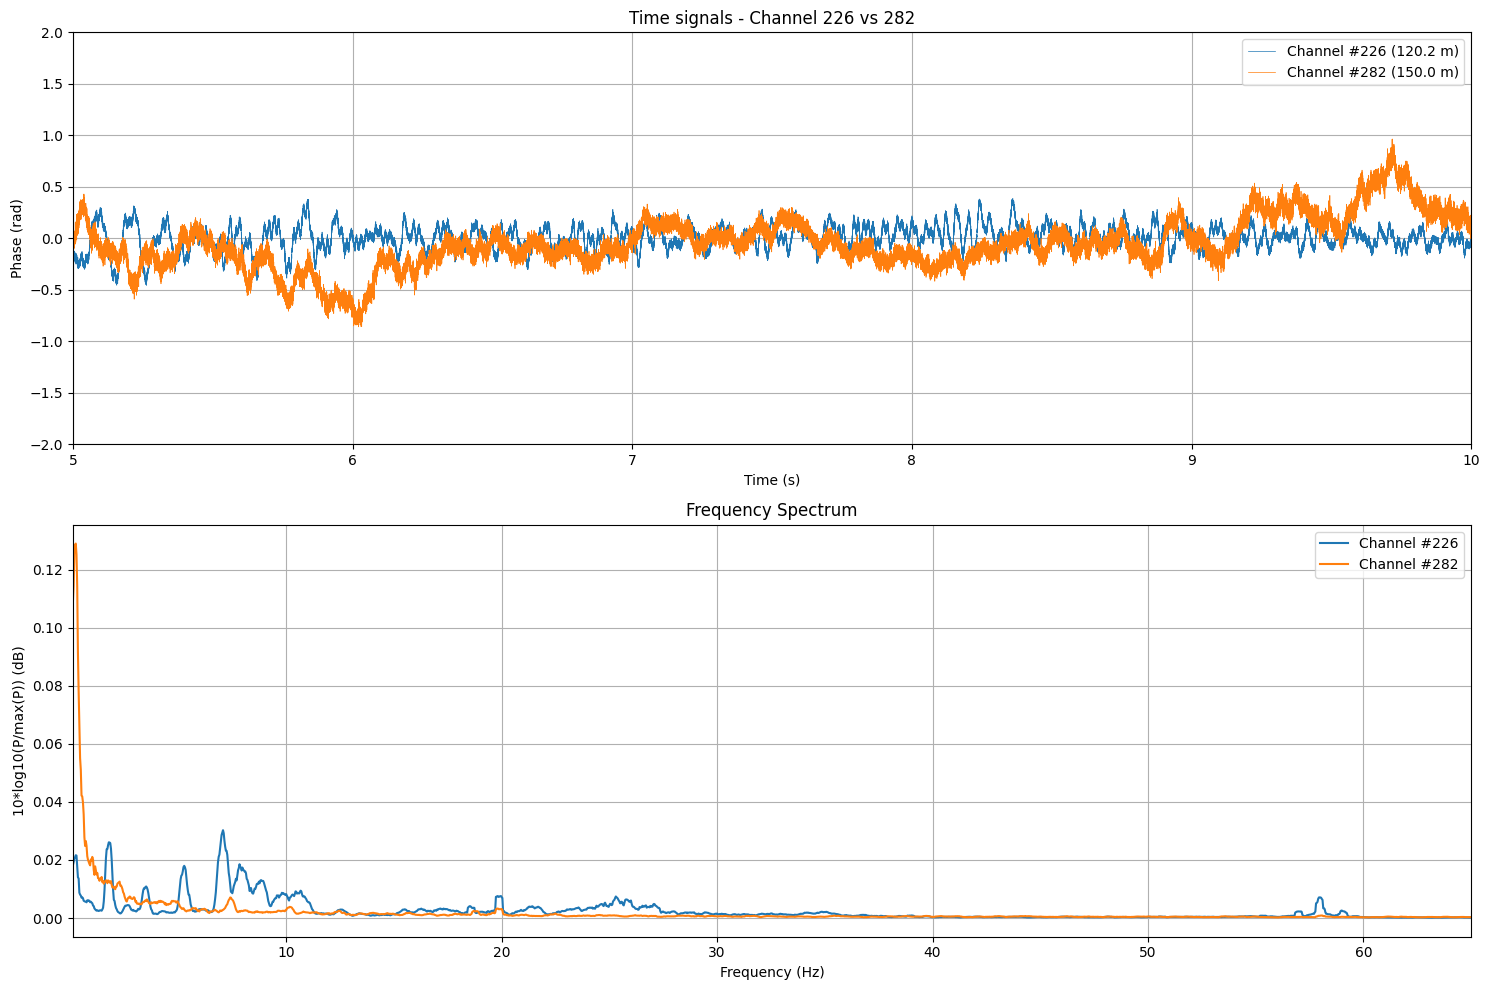

In [15]:
'''
========================================================================
5. INITIAL VISUALIZATION (Figure 1)
========================================================================
'''
print('Generating visualizations...')

# Find channels for visualization
chan_view = np.argmin(np.abs(y - startFiberProfile))
chan_view2 = np.argmin(np.abs(y - endFiberProfile))

# Get positions - handle both scalar and array cases
if y.ndim == 0 or y.size == 1:
    pos1 = float(y)
    pos2 = float(y)
elif y.ndim == 1:
    pos1 = float(y[chan_view].item()) if hasattr(y[chan_view], 'item') else y[chan_view]
    pos2 = float(y[chan_view2].item()) if hasattr(y[chan_view2], 'item') else y[chan_view2]
else:
    pos1 = y.flat[chan_view]
    pos2 = y.flat[chan_view2]

print(f' -> Channel 1 ({startFiberProfile} m) selected: #{chan_view} (Real position: {pos1:.2f} m)')
print(f' -> Channel 2 ({endFiberProfile} m) selected: #{chan_view2} (Real position: {pos2:.2f} m)')

# Figure 1: Time signals and FFT
plt.figure(figsize=(15, 10))

# Subplot 1: Time signals
nshow = min(num_tr, int(10 * fs))  # Show first 10 seconds
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t[:nshow], X[chan_view, :nshow], label=f'Channel #{chan_view} ({pos1:.1f} m)', linewidth=0.5)
ax1.plot(t[:nshow], X[chan_view2, :nshow], label=f'Channel #{chan_view2} ({pos2:.1f} m)', linewidth=0.5)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Phase (rad)')
ax1.set_title(f'Time signals - Channel {chan_view} vs {chan_view2}')
ax1.legend()
ax1.grid(True)
ax1.set_xlim([t[0], min(t[0] + 5, t[-1])])  # Show first 5 seconds or less
ax1.set_ylim([phase_min, phase_max])


# Subplot 2: FFT
signal1 = X[chan_view, :]
signal2 = X[chan_view2, :]

L = num_tr
f = fs * np.arange(0, L//2 + 1) / L

Y1 = np.fft.fft(signal1)
P2_1 = np.abs(Y1 / L)
P1_1 = P2_1[:L//2 + 1]
P1_1[1:-1] = 2 * P1_1[1:-1]

Y2 = np.fft.fft(signal2)
P2_2 = np.abs(Y2 / L)
P1_2 = P2_2[:L//2 + 1]
P1_2[1:-1] = 2 * P1_2[1:-1]

def smooth(x, window):
    window = int(window)
    return np.convolve(x, np.ones(window)/window, mode='same')

ax2 = plt.subplot(2, 1, 2)



ax2.plot(f, smooth(P1_1, 10), label=f'Channel #{chan_view}')
ax2.plot(f, smooth(P1_2, 10), label=f'Channel #{chan_view2}')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('10*log10(P/max(P)) (dB)')
ax2.set_title('Frequency Spectrum')
ax2.legend()
ax2.grid(True)
ax2.set_xlim([0.1, min(65, fs/2)])  # Limit to Nyquist

plt.tight_layout()
plt.show()

In [16]:
'''
========================================================================
6. CROSS-CORRELATION AND VELOCITY
========================================================================
'''
print('Calculating cross-correlation...')

c, lags, time_delay = cross_correlation(signal1, signal2, fs)

# Calculate velocity
distance_m = abs(y[chan_view2, 0] - y[chan_view, 0]) * scale_factor
velocity = abs(distance_m / (time_delay + 1e-10))

print('\n--- Cross-Correlation Results ---')
print(f' -> Distance between channels: {distance_m:.2f} m')
print(f' -> Time delay: {time_delay:.4f} s')
print(f' -> Apparent velocity: {velocity:.2f} m/s')

Calculating cross-correlation...

--- Cross-Correlation Results ---
 -> Distance between channels: 0.68 m
 -> Time delay: -5.0812 s
 -> Apparent velocity: 0.13 m/s


Generating temporal PSD map...
Computing spectrogram with integrated band...
Computation completed in 148.60 seconds


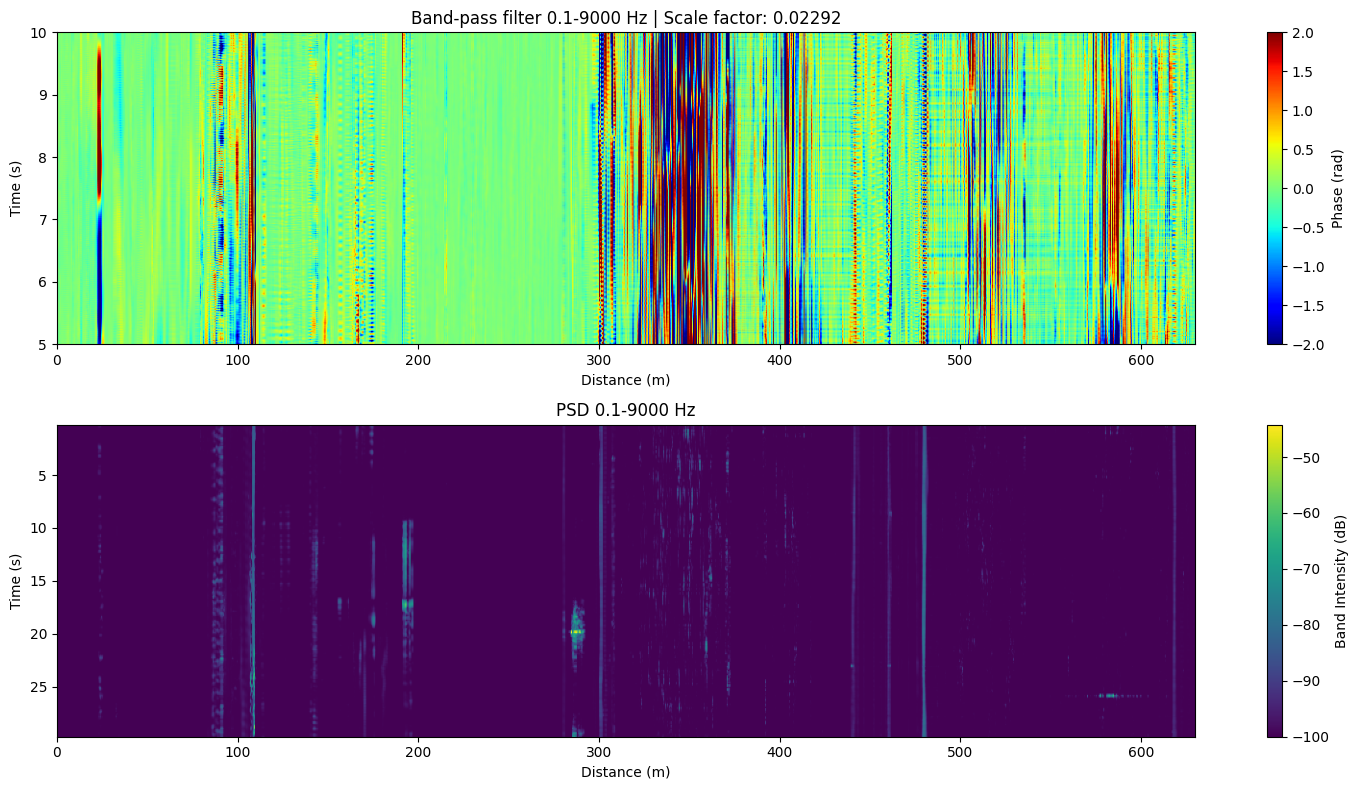

In [17]:
'''
========================================================================
7. TEMPORAL PSD MAP (Figure 2)
========================================================================
'''
print('Generating temporal PSD map...')

freq_band = [hp_cut, min(lp_cut, fs/2 - 1)]  # Ensure it doesn't exceed Nyquist
try:
    PSD_map, t_spec = integrated_band_spectrogram(X, fs, freq_band)

    plt.figure(figsize=(15, 8))

    # Subplot 1: Phase map
    ax1 = plt.subplot(2, 1, 1)
    im1 = ax1.imshow(X[:, :nshow].T, aspect='auto',
                     extent=[y[0], y[-1], t[nshow-1], t[0]],
                     cmap='jet', vmin=phase_min, vmax=phase_max)
    ax1.set_xlabel('Distance (m)')
    ax1.set_ylabel('Time (s)')
    ax1.set_title(f'Band-pass filter {hp_cut}-{lp_cut} Hz | Scale factor: {scale_factor}')
    plt.colorbar(im1, ax=ax1, label='Phase (rad)')
    ax1.set_xlim([y[0], min(630, y[-1])])
    ax1.set_ylim([max(t[0], 5), min(10, t[-1])])

    # Subplot 2: PSD map
    ax2 = plt.subplot(2, 1, 2)
    PSD_dB = 10 * np.log10(PSD_map + 1e-10)
    im2 = ax2.imshow(PSD_dB.T, aspect='auto',
                     extent=[y[0], y[-1], t_spec[-1], t_spec[0]],
                     cmap='viridis')
    ax2.set_xlabel('Distance (m)')
    ax2.set_ylabel('Time (s)')
    ax2.set_title(f'PSD {freq_band[0]}-{freq_band[1]} Hz')
    plt.colorbar(im2, ax=ax2, label='Band Intensity (dB)')
    ax2.set_xlim([y[0], min(630, y[-1])])

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error generating PSD map: {e}")


--- Selected Region of Interest [30.30952455], [199.40476678] , 57, 376 ---
 Scale Factor: 0.02292 New Scale Factor: [3.87566295]


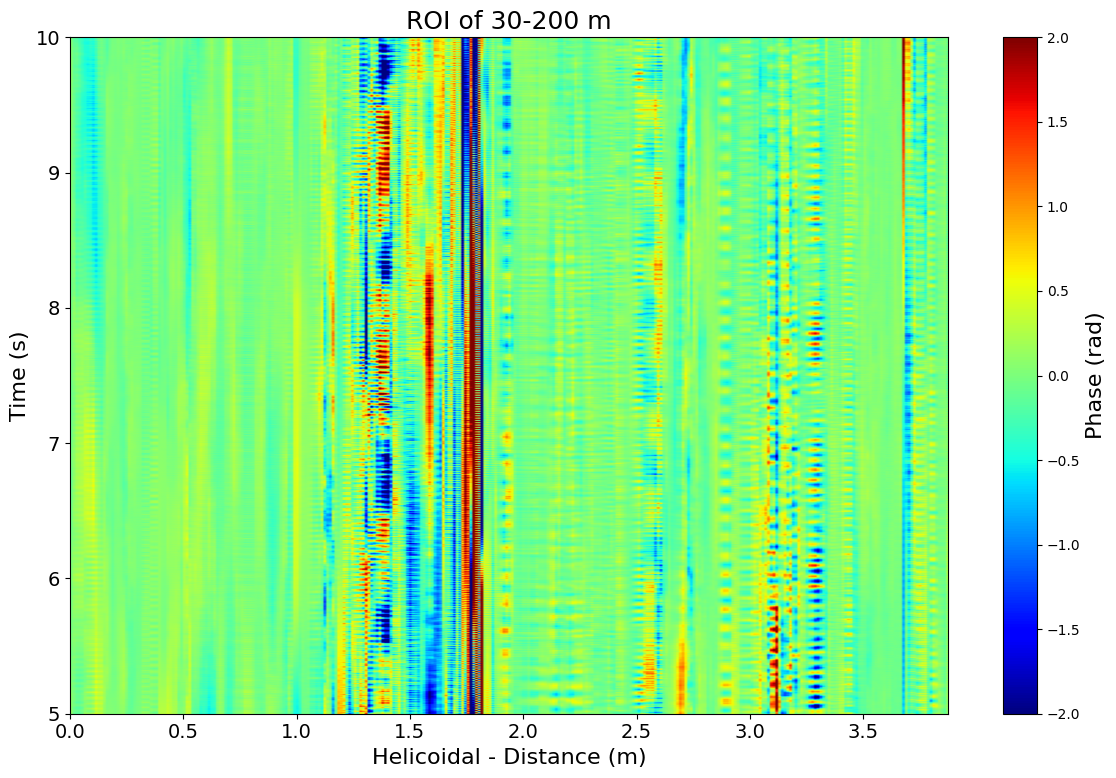

In [18]:
'''
========================================================================
8. REGION OF INTEREST WITH SCALE (Figure 3)
========================================================================
'''

# Scale definition
dist_roi_start = startFiber
dist_roi_end = endFiber

# Data Selection

idx_roi_start = np.where(y >= dist_roi_start)[0][0]
idx_roi_end = np.where(y <= dist_roi_end)[0][-1]
X_roi = X[idx_roi_start:idx_roi_end, :]
y_roi = y[idx_roi_start:idx_roi_end, :]

print(f'\n--- Selected Region of Interest {y_roi[0]}, {y_roi[-1]} , {idx_roi_start}, {idx_roi_end} ---')

'''
 Relative Scale Application (Principal Correction)
'''

y_relativo = y_roi - y_roi[0]
y_final_axis = y_relativo * scale_factor

delta_final = y_final_axis[-1] - y_final_axis[0]

print(f' Scale Factor: {scale_factor} New Scale Factor: {delta_final}')

plt.figure(figsize=(12, 8))
im = plt.imshow(X_roi.T,
                aspect='auto',
                origin='lower',  # Equivalente a axis xy en MATLAB
                extent=[y_final_axis[0], y_final_axis[-1], t[0], t[-1]],
                cmap='jet')
im.set_clim(vmin=phase_min, vmax=phase_max)
cbar = plt.colorbar(im)
cbar.set_label('Phase (rad)', fontsize=16)
plt.ylim([5, 10])
plt.xlabel('Helicoidal - Distance (m)', fontsize=16)
plt.ylabel('Time (s)', fontsize=16)
plt.title(f'ROI of {dist_roi_start:.0f}-{dist_roi_end:.0f} m', fontsize=18)
plt.rcParams.update({'font.size': 14})
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

Iniciando plot da região de interesse (ROI)...
Procurando ROI de 30 m a 200 m
Range de y: 0.00 a 986.39 m
Região de Interesse selecionada:
  - Posição: 30.3 m a 199.9 m
  - Canais: 57 a 376
  - Tamanho de X_roi: (320, 600001)
Fator de escala:
  - Original: 0.02292
  - Novo delta do eixo: 3.888 metros
  - Range do eixo final: 0.000 a 3.888 m

Removendo faixas horizontais (ruído de modo comum)...
  - Shape da média: (600001,)
  - Shape após filtro: (320, 600001)

Criando figura...


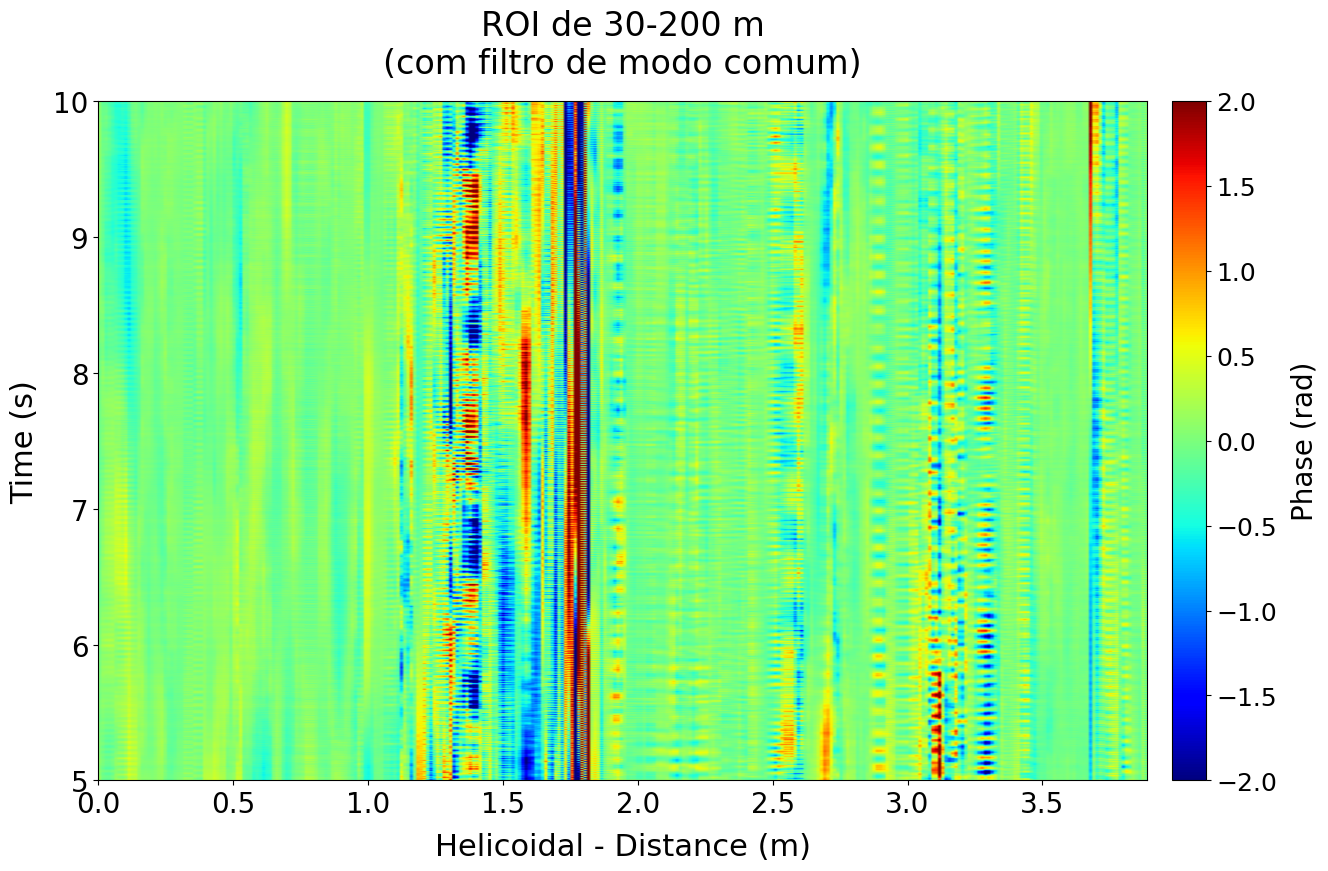

Plot da região de interesse concluído com sucesso!


In [19]:
print('Iniciando plot da região de interesse (ROI)...')

# --- 1. Definição da ROI e do Fator de Escala ---
dist_roi_start = startFiber
dist_roi_end = endFiber

print(f'Procurando ROI de {dist_roi_start} m a {dist_roi_end} m')
print(f'Range de y: {y.min():.2f} a {y.max():.2f} m')

# --- 2. Seleção dos Dados ---
# Encontrar índices
idx_mask_start = y >= dist_roi_start
idx_mask_end = y <= dist_roi_end

if np.any(idx_mask_start) and np.any(idx_mask_end):
    idx_roi_start = np.where(idx_mask_start)[0][0]
    idx_roi_end = np.where(idx_mask_end)[0][-1]
else:
    print(f'ERRO: Não foi possível encontrar ROI no range especificado')
    print(f'Sugestão: ajuste startFiber e endFiber entre {y.min():.2f} e {y.max():.2f}')
    # Usar todo o range como fallback
    idx_roi_start = 0
    idx_roi_end = len(y) - 1
    dist_roi_start = float(y[idx_roi_start])
    dist_roi_end = float(y[idx_roi_end])

X_roi = X[idx_roi_start:idx_roi_end+1, :]

# Asegurar que y es un array 1D
if len(y.shape) > 1:
    y_flat = y.flatten()
else:
    y_flat = y

y_roi = y_flat[idx_roi_start:idx_roi_end+1]

print(f'Região de Interesse selecionada:')
print(f'  - Posição: {float(y_roi[0]):.1f} m a {float(y_roi[-1]):.1f} m')
print(f'  - Canais: {idx_roi_start} a {idx_roi_end}')
print(f'  - Tamanho de X_roi: {X_roi.shape}')

# --- 3. Aplicação da Escala Relativa ---
y_relativo = y_roi - y_roi[0]
y_final_axis = y_relativo * scale_factor

# Convertir a float para evitar problemas de formato
y_start = float(y_final_axis[0])
y_end = float(y_final_axis[-1])
delta_final = y_end - y_start

print(f'Fator de escala:')
print(f'  - Original: {scale_factor:.5f}')
print(f'  - Novo delta do eixo: {delta_final:.3f} metros')
print(f'  - Range do eixo final: {y_start:.3f} a {y_end:.3f} m')

# =========================================================================
# --- 3.5: REMOÇÃO DE RUÍDO DE MODO COMUM (FILTRO ESPACIAL) ---
# =========================================================================
print('\nRemovendo faixas horizontais (ruído de modo comum)...')

# Calcular média temporal
mean_trace_over_time = np.mean(X_roi, axis=0)
print(f'  - Shape da média: {mean_trace_over_time.shape}')

# Aplicar filtro de modo comum
X_roi_filtered = X_roi - 0.5 * mean_trace_over_time[np.newaxis, :]
print(f'  - Shape após filtro: {X_roi_filtered.shape}')

# =========================================================================
# --- 4. Plot da Nova Figura ---
print('\nCriando figura...')
plt.figure(figsize=(14, 9))

# Preparar datos para el plot
# Asegurar que t sea 1D
if len(t.shape) > 1:
    t_flat = t.flatten()
else:
    t_flat = t

t_min = float(t_flat[0])
t_max = float(t_flat[-1])

# Crear el plot
im = plt.imshow(X_roi_filtered.T,
                aspect='auto',
                origin='lower',
                extent=[y_start, y_end, t_min, t_max],
                cmap='jet',
                vmin=phase_min,
                vmax=phase_max)

# Colorbar
cbar = plt.colorbar(im, pad=0.02)
cbar.set_label('Phase (rad)', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=18)

# Límites del eje Y
plt.ylim([5, 10])

# Configurar fuente
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)

# Etiquetas y título
plt.xlabel('Helicoidal - Distance (m)', fontsize=22, labelpad=10)
plt.ylabel('Time (s)', fontsize=22, labelpad=10)
plt.title(f'ROI de {dist_roi_start:.0f}-{dist_roi_end:.0f} m\n(com filtro de modo comum)',
          fontsize=24, pad=20)

# Grid opcional
# plt.grid(True, alpha=0.3, linestyle='--')

# Ajustar y mostrar
plt.tight_layout()
plt.show()

print('Plot da região de interesse concluído com sucesso!')

Processing region of interest...
Range of y: 0.00 to 986.39 m
Looking for ROI: 30 to 200 m
ROI found: channels 57 to 376
Actual range in y: 30.31 to 199.94 m
Showing time from 5.0 to 10.0 seconds


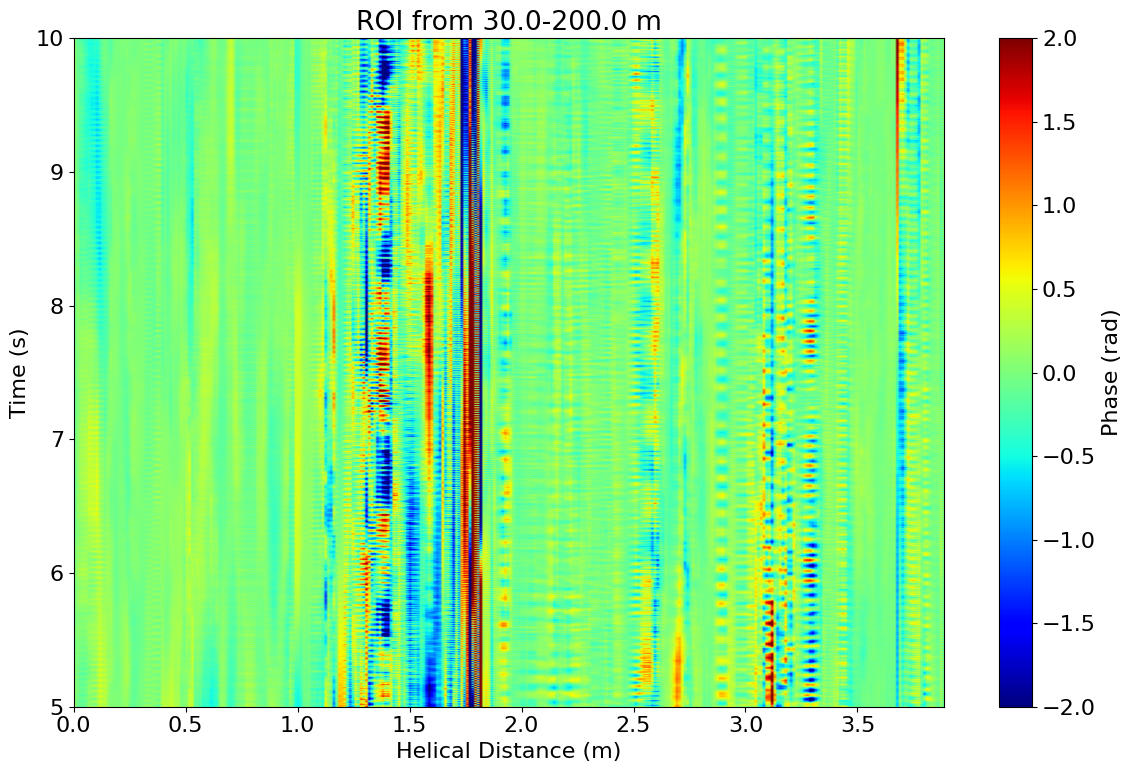

In [20]:
'''
========================================================================
9. REGION OF INTEREST WITH SCALE - WITH FILTER (Figure 5)
========================================================================
'''
print('Processing region of interest...')

# Debug: Show range information
try:
    # Convert entire y array to float once
    y_float_full = np.array(y, dtype=float).flatten()

    if len(y_float_full) > 0:
        y_min_val = float(y_float_full[0])
        y_max_val = float(y_float_full[-1])
        print(f"Range of y: {y_min_val:.2f} to {y_max_val:.2f} m")
    else:
        print("ERROR: y array is empty")
        y_min_val = 0
        y_max_val = 0
except Exception as e:
    print(f"Error accessing y array: {e}")
    print(f"y type: {type(y)}, shape: {y.shape if hasattr(y, 'shape') else 'N/A'}")
    print(f"y dtype: {y.dtype if hasattr(y, 'dtype') else 'N/A'}")
    if hasattr(y, '__len__') and len(y) > 0:
        print(f"First element: {y[0]}, type: {type(y[0])}")
    y_min_val = 0
    y_max_val = 0

print(f"Looking for ROI: {startFiber} to {endFiber} m")

# Select ROI - Use the pre-converted float array
try:
    # Use the float array
    mask = (y_float_full >= startFiber) & (y_float_full <= endFiber)
    indices_roi = np.where(mask)[0]
except Exception as e:
    print(f"Error creating mask: {e}")
    indices_roi = np.array([])

if len(indices_roi) == 0:
    print(f"ERROR: No channels found in range {startFiber}-{endFiber} m")
    print("Possible solutions:")
    print(f"1. Check that startFiber ({startFiber}) <= endFiber ({endFiber})")

    if len(y_float_full) > 0:
        y_min_val = float(np.min(y_float_full))
        y_max_val = float(np.max(y_float_full))

        print(f"2. Check that startFiber ({startFiber}) >= y minimum ({y_min_val:.2f})")
        print(f"3. Check that endFiber ({endFiber}) <= y maximum ({y_max_val:.2f})")

        # Suggest close values
        if startFiber < y_min_val:
            print(f"Suggestion: startFiber should be >= {y_min_val:.2f}")
        if endFiber > y_max_val:
            print(f"Suggestion: endFiber should be <= {y_max_val:.2f}")

        # Use available ranges if ROI not found
        new_startFiber = startFiber
        new_endFiber = endFiber

        if startFiber < y_min_val:
            new_startFiber = y_min_val
            print(f"Using startFiber = {new_startFiber:.2f}")
        if endFiber > y_max_val:
            new_endFiber = y_max_val
            print(f"Using endFiber = {new_endFiber:.2f}")

        # Recalculate mask with new values
        mask = (y_float_full >= new_startFiber) & (y_float_full <= new_endFiber)
        indices_roi = np.where(mask)[0]

        # Update startFiber and endFiber if we used new values
        startFiber = new_startFiber
        endFiber = new_endFiber

if len(indices_roi) > 0:
    idx_roi_start = indices_roi[0]
    idx_roi_end = indices_roi[-1]

    # Get values as Python floats
    y_start_val = float(y_float_full[idx_roi_start])
    y_end_val = float(y_float_full[idx_roi_end])

    print(f"ROI found: channels {idx_roi_start} to {idx_roi_end}")
    print(f"Actual range in y: {y_start_val:.2f} to {y_end_val:.2f} m")

    X_roi = X[idx_roi_start:idx_roi_end+1, :]
    y_roi = y_float_full[idx_roi_start:idx_roi_end+1]

    # Apply scale
    y_relative = y_roi - y_roi[0]
    y_final_axis = y_relative * scale_factor

    # Calculate time limits for visualization
    # Convert t array to float
    t_float_full = np.array(t, dtype=float).flatten()

    if len(t_float_full) > 0:
        t_min_val = float(t_float_full[0])
        t_max_val = float(t_float_full[-1])
        t_min_vis = max(t_min_val, 5.0)
        t_max_vis = min(t_max_val, 10.0)
    else:
        t_min_val = 0
        t_max_val = 0
        t_min_vis = 0
        t_max_vis = 0

    # Create figure
    plt.figure(figsize=(12, 8))

    # Check that data is not empty
    if X_roi.size > 0:
        # Create the image
        if len(t_float_full) > 0:
            t_start_val = t_min_val
            t_end_val = t_max_val
        else:
            t_start_val = 0
            t_end_val = 0

        im = plt.imshow(X_roi.T,
                        aspect='auto',
                        origin='lower',
                        extent=[float(y_final_axis[0]), float(y_final_axis[-1]),
                                t_start_val, t_end_val],
                        cmap='jet',
                        vmin=phase_min,
                        vmax=phase_max)

        plt.xlabel('Helical Distance (m)')
        plt.ylabel('Time (s)')
        plt.title(f'ROI from {startFiber:.1f}-{endFiber:.1f} m')
        plt.colorbar(im, label='Phase (rad)')

        # Adjust Y-axis limits if possible
        if t_min_vis < t_max_vis and t_max_vis > 0:
            plt.ylim([t_min_vis, t_max_vis])
            print(f"Showing time from {t_min_vis:.1f} to {t_max_vis:.1f} seconds")
        elif t_end_val > 0:
            plt.ylim([t_start_val, t_end_val])
            print(f"Showing all time: {t_start_val:.1f} to {t_end_val:.1f} seconds")

        plt.tight_layout()
        plt.show()
    else:
        print("ERROR: X_roi is empty, cannot create figure")
else:
    print(f"ERROR: No channels found after adjusting parameters")
    if len(y_float_full) > 0:
        y_min_val = float(np.min(y_float_full))
        y_max_val = float(np.max(y_float_full))
        print(f"Available y range: {y_min_val:.2f} to {y_max_val:.2f} m")

Performing 2D FFT analysis...


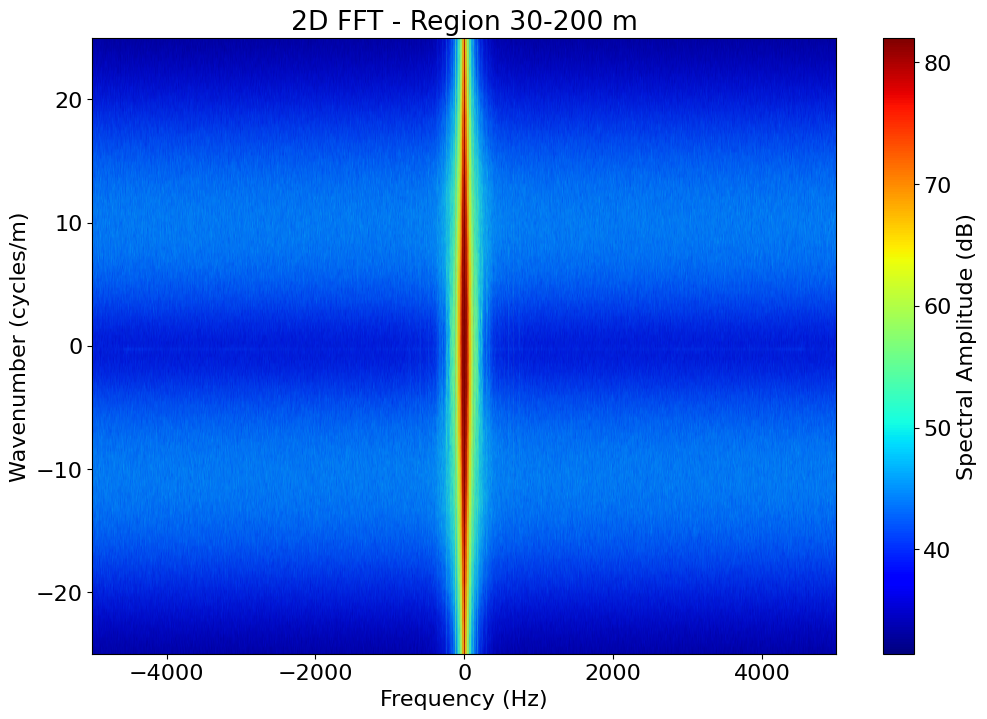

In [21]:
'''
========================================================================
10. 2D FFT (K-F ANALYSIS) (Figure 6)
========================================================================
'''
print('Performing 2D FFT analysis...')

if X_roi is not None and X_roi.shape[0] > 0 and X_roi.shape[1] > 0:
    F_dB, f_vec, k_vec = fft_2d_analysis(X_roi, fs, dx, scale_factor)

    plt.figure(figsize=(12, 8))
    im = plt.imshow(F_dB, aspect='auto',
                    extent=[f_vec[0], f_vec[-1], k_vec[0], k_vec[-1]],
                    cmap='jet',
                    vmin=np.percentile(F_dB, 30),
                    vmax=np.percentile(F_dB, 99.9))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Wavenumber (cycles/m)')
    plt.title(f'2D FFT - Region {startFiber}-{endFiber} m')
    plt.colorbar(im, label='Spectral Amplitude (dB)')
    plt.xlim([-min(5000, fs/2), min(5000, fs/2)])
    plt.ylim([-25, 25])
    plt.savefig('figure5_fft2d.png', dpi=300)
    plt.show()

Starting 2D FFT analysis (k-f) with filters and temporal averaging...
Analyzing region from [30.30952455] m to [199.93651282] m (channels 57 to 376).
Removing common mode strips (time average)...
Applying spatial high-pass filter...
Spatial filters applied.
Starting stacking: 991 chunks of 0.30 s each.
Stacking completed in 78.89 seconds.
Wavenumber axis calculated using scaled dx of 0.01219.


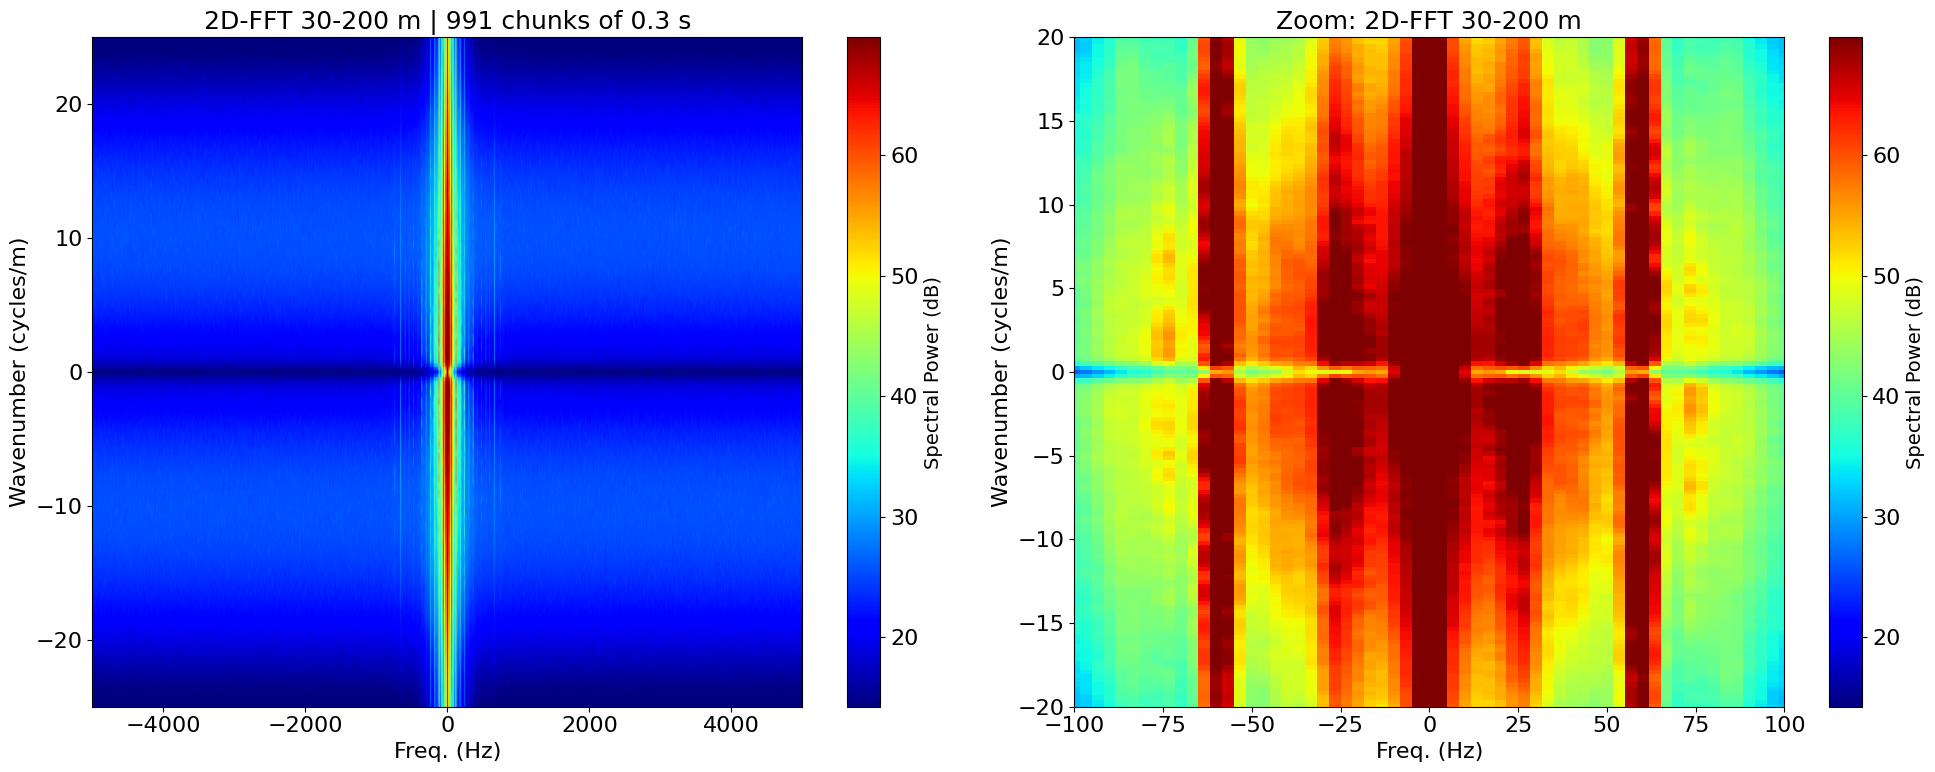

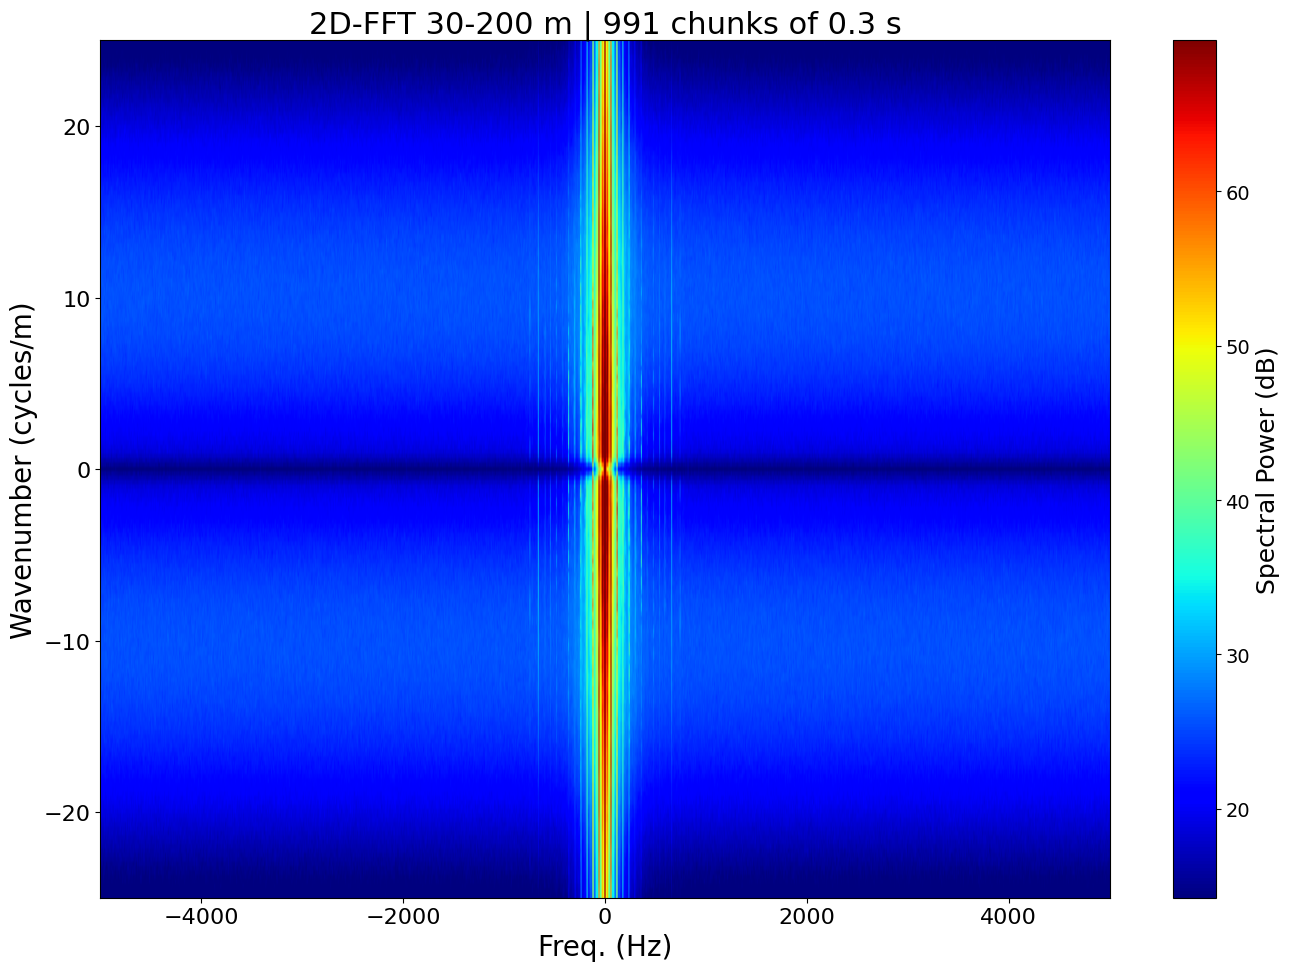

2D FFT analysis completed.


In [22]:
'''
========================================================================
11. 2D FFT (K-F ANALYSIS) WITH SPACIAL FILTER AND TEMPORAL MEAN (Figure 7)
========================================================================
'''
print('Starting 2D FFT analysis (k-f) with filters and temporal averaging...')

# --- 1. ROI Definition and Scale Factor (same as before) ---
dist_start = startFiber
dist_final = endFiber

# --- 2. ROI Data Selection (same as before) ---
idx_y_start = np.where(y >= dist_start)[0][0]
idx_y_end = np.where(y <= dist_final)[0][-1]
X_roi_raw = X[idx_y_start:idx_y_end+1, :]

print(f'Analyzing region from {y[idx_y_start]} m to {y[idx_y_end]} m (channels {idx_y_start} to {idx_y_end}).')

# --- 3. SPATIAL FILTERS APPLICATION (Solution 1) ---
print('Removing common mode strips (time average)...')
mean_trace_over_time = np.mean(X_roi_raw, axis=0)
X_roi_filtered_A = X_roi_raw - mean_trace_over_time

print('Applying spatial high-pass filter...')
k_cut = 0.50
dx_scaled_filter = dx * scale_factor
fs_spatial = 1 / dx_scaled_filter

# Design butterworth filter
b, a = butter(2, k_cut / (fs_spatial / 2), btype='high')

P = X_roi_filtered_A.T  # Matrix [Time x Distance]
P_filtered = np.zeros_like(P)

# Apply filter along spatial dimension (for each time sample)
for i in range(P.shape[0]):
    P_filtered[i, :] = filtfilt(b, a, P[i, :])

X_roi_filtered = P_filtered.T  # Spatially cleaned data
print('Spatial filters applied.')

# =========================================================================
# --- 4. NEW PARAMETERS: Time Window and Overlap (Solution 2) ---
# =========================================================================

# Duration of each FFT "chunk" in seconds.
# (Smaller = More averaging, less noise, BUT less frequency resolution)
T_chunk_sec = 0.3  # [s] Duration of each temporal window (ADJUST HERE)

# Overlap of windows (0.5 = 50%)
T_overlap_perc = 0.9

# --- 5. Preparation for Averaging Loop ---
Ny, Nt_total = X_roi_filtered.shape

# Convert time to samples
N_chunk_t = int(round(T_chunk_sec * fs))
N_overlap_t = int(round(T_overlap_perc * N_chunk_t))
N_step_t = N_chunk_t - N_overlap_t

# Windows
win_y = np.hanning(Ny)
win_t = np.hanning(N_chunk_t)
win_2d = win_y[:, np.newaxis] * win_t[np.newaxis, :]  # 2D window

# Calculate number of chunks that fit
N_chunks = int(np.floor((Nt_total - N_overlap_t) / N_step_t))
if N_chunks < 1:
    raise ValueError(f'ROI data ({Nt_total/fs:.2f} s) is shorter than window ({T_chunk_sec:.2f} s).')

print(f'Starting stacking: {N_chunks} chunks of {T_chunk_sec:.2f} s each.')

# Matrix to accumulate SUM of power spectra
F_power_sum = np.zeros((Ny, N_chunk_t))

start_time = time.time()
# Use simple for loop
for i_chunk in range(N_chunks):
    # Find time indices for this chunk
    idx_t_start = i_chunk * N_step_t
    idx_t_end = idx_t_start + N_chunk_t

    # Extract data chunk (already spatially filtered)
    X_chunk = X_roi_filtered[:, idx_t_start:idx_t_end]

    # Apply 2D window
    X_win = X_chunk * win_2d

    # Calculate 2D FFT of chunk
    F_chunk = np.fft.fftshift(np.fft.fft2(X_win))

    # Calculate Power Spectrum (NOT in dB yet)
    F_power_chunk = np.abs(F_chunk)**2

    # Add to total sum
    F_power_sum += F_power_chunk

elapsed_time = time.time() - start_time
print(f'Stacking completed in {elapsed_time:.2f} seconds.')

# Calculate average
F_power_avg = F_power_sum / N_chunks

# Convert to dB
# *** We use 10*log10 because we're dealing with POWER (amplitude^2) ***
F_dB = 10 * np.log10(F_power_avg + 1e-10)  # Add small value to avoid log10(0)

# --- 6. CREATION OF k-f AXES (BASED ON CHUNK) ---

# Temporal Frequency Axis (Hz) - based on N_chunk_t
Nt_chunk = N_chunk_t
f_vec = np.fft.fftshift(np.fft.fftfreq(Nt_chunk, 1/fs))

# Wavenumber Axis (same as before)
dx_scaled = dx * scale_factor
k_nyquist_scaled = 1 / (2 * dx_scaled)
k_vec_scaled = np.fft.fftshift(np.fft.fftfreq(Ny, dx_scaled))

print(f'Wavenumber axis calculated using scaled dx of {dx_scaled:.5f}.')

# --- 7. Visualization of Final k-f Plot (with averaging) ---
# Figure 54 - Two subplots
fig54 = plt.figure(54, figsize=(20, 8))

# First subplot: Full frequency range
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(F_dB,
                 aspect='auto',
                 origin='lower',
                 extent=[f_vec[0], f_vec[-1], k_vec_scaled[0], k_vec_scaled[-1]],
                 cmap='jet')

ax1.set_xlim([-5000, 5000])
ax1.set_ylim([-25, 25])
ax1.set_xlabel('Freq. (Hz)', fontsize=16)
ax1.set_ylabel('Wavenumber (cycles/m)', fontsize=16)
ax1.set_title(f'2D-FFT {dist_start:.0f}-{dist_final:.0f} m | {N_chunks} chunks of {T_chunk_sec:.1f} s', fontsize=18)

cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Spectral Power (dB)', fontsize=14)

# Adjust contrast (percentile-based)
cl_kf = np.percentile(F_dB.flatten(), [30, 99.9])
im1.set_clim(cl_kf)

# Second subplot: Zoomed frequency range
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(F_dB,
                 aspect='auto',
                 origin='lower',
                 extent=[f_vec[0], f_vec[-1], k_vec_scaled[0], k_vec_scaled[-1]],
                 cmap='jet')

ax2.set_xlim([-100, 100])
ax2.set_ylim([-20, 20])
ax2.set_xlabel('Freq. (Hz)', fontsize=16)
ax2.set_ylabel('Wavenumber (cycles/m)', fontsize=16)
ax2.set_title(f'Zoom: 2D-FFT {dist_start:.0f}-{dist_final:.0f} m', fontsize=18)

cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Spectral Power (dB)', fontsize=14)
im2.set_clim(cl_kf)

plt.tight_layout()
plt.show()

# Figure 55 - Single large plot
fig55 = plt.figure(figsize=(14, 10))
im3 = plt.imshow(F_dB,
                 aspect='auto',
                 origin='lower',
                 extent=[f_vec[0], f_vec[-1], k_vec_scaled[0], k_vec_scaled[-1]],
                 cmap='jet')

plt.xlim([-5000, 5000])
plt.ylim([-25, 25])
plt.xlabel('Freq. (Hz)', fontsize=20)
plt.ylabel('Wavenumber (cycles/m)', fontsize=20)
plt.title(f'2D-FFT {dist_start:.0f}-{dist_final:.0f} m | {N_chunks} chunks of {T_chunk_sec:.1f} s', fontsize=22)

cbar3 = plt.colorbar(im3)
cbar3.set_label('Spectral Power (dB)', fontsize=18)
cbar3.ax.tick_params(labelsize=14)

# Adjust contrast
im3.set_clim(cl_kf)

plt.tight_layout()
plt.show()

print('2D FFT analysis completed.')

Starting FFT calculation for spatial range...

FFT Analysis in Range from [120.17460611] m to [149.95238461] m (Sampling: every 4 channels)
 -> 15 Selected Channels: [226 230 234 238 242 246 250 254 258 262 266 270 274 278 282]
Signal length L = 600001 (odd)
Frequency vector length: 300001 points (0 to 9999.983333361111 Hz)


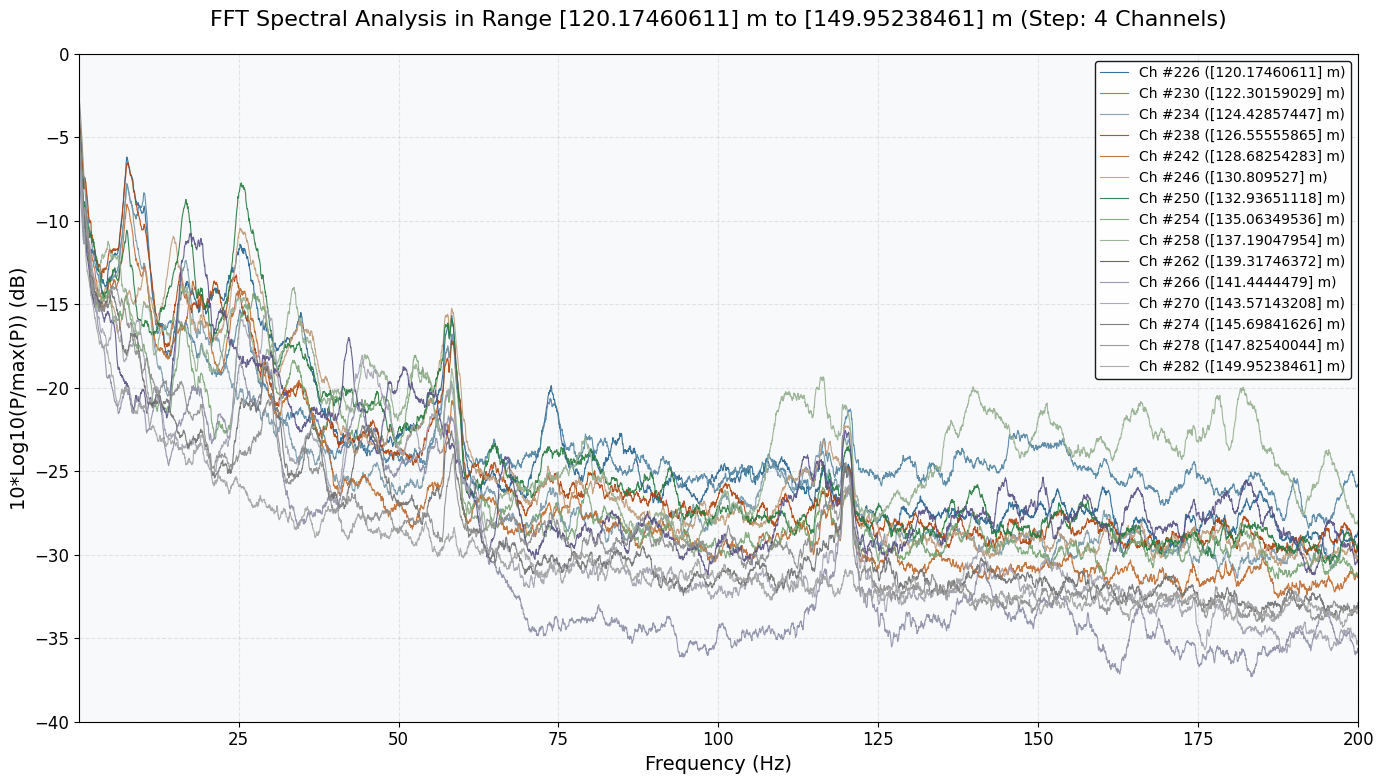

FFT calculation for range completed.


In [23]:
'''
========================================================================
12.  FFT Analysis for Selected Spatial Range (Figure 8)
========================================================================
'''
start_m_fft = startFiberProfile
end_m_fft = endFiberProfile
channel_step = 4

print('Starting FFT calculation for spatial range...')

start_chan_fft = np.argmin(np.abs(y - start_m_fft))
end_chan_fft = np.argmin(np.abs(y - end_m_fft))

if start_chan_fft > end_chan_fft:
    start_chan_fft, end_chan_fft = end_chan_fft, start_chan_fft

selected_channels = np.arange(start_chan_fft, end_chan_fft + 1, channel_step)

print(f'\nFFT Analysis in Range from {y[start_chan_fft]} m to {y[end_chan_fft]} m (Sampling: every {channel_step} channels)')
print(f' -> {len(selected_channels)} Selected Channels: {selected_channels}')

L = num_tr

print(f'Signal length L = {L} ({"even" if L % 2 == 0 else "odd"})')

if L % 2 == 0:
    f = fs * np.arange(0, L//2 + 1) / L
    fft_points = L//2 + 1
else:
    f = fs * np.arange(0, (L+1)//2) / L
    fft_points = (L+1)//2

print(f'Frequency vector length: {len(f)} points (0 to {f[-1]} Hz)')

plt.figure(figsize=(14, 8))

base_colors = plt.cm.tab20c(np.linspace(0, 1, len(selected_channels)))
colors = []
for color in base_colors:
    r, g, b, a = color
    dark_factor = 0.75
    colors.append((r * dark_factor, g * dark_factor, b * dark_factor, a))

for i, chan_idx in enumerate(selected_channels):
    signal = X[chan_idx, :]

    Y = np.fft.fft(signal)
    P2 = np.abs(Y / L)

    if L % 2 == 0:
        P1 = P2[:L//2 + 1]
        P1[1:-1] = 2 * P1[1:-1]
    else:
        P1 = P2[:(L+1)//2]
        P1[1:] = 2 * P1[1:]

    if len(P1) != len(f):
        min_len = min(len(P1), len(f))
        P1 = P1[:min_len]
        f_plot = f[:min_len]
    else:
        f_plot = f

    P1_max = np.max(P1)
    if P1_max > 0:
        P1_dB = 10 * np.log10(P1 / P1_max)
    else:
        P1_dB = np.zeros_like(P1)

    window_size = 51
    if len(P1_dB) >= window_size:
        P1_smooth = np.convolve(P1_dB, np.ones(window_size)/window_size, mode='same')
    else:
        P1_smooth = P1_dB

    plt.plot(f_plot, P1_smooth, color=colors[i], linewidth=0.8, alpha=0.9,
             label=f'Ch #{chan_idx} ({y[chan_idx]} m)')

plt.grid(True, alpha=0.3, linestyle='--')

ax = plt.gca()
ax.set_facecolor('#f8f9fa')

plt.title(f'FFT Spectral Analysis in Range {y[start_chan_fft]} m to {y[end_chan_fft]} m (Step: {channel_step} Channels)',
          fontsize=16, pad=20)
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('10*Log10(P/max(P)) (dB)', fontsize=14)

plt.legend(loc='best', fontsize=10, framealpha=0.9,
           edgecolor='black', fancybox=True)

plt.xlim([0.1, 200])
plt.ylim([-40, 0])

plt.rcParams.update({'font.size': 12})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.axhline(y=0, color='black', linestyle=':', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

print('FFT calculation for range completed.')

In [ ]:
# %% --- Cross-Correlation Analysis for Selected Range ---

print('Starting Cross-Correlation calculation for range...')

ref_chan_idx = selected_channels[0]
signal_ref = X[ref_chan_idx, :]

plt.figure(figsize=(14, 8))

colors_corr = plt.cm.tab20c(np.linspace(0, 1, len(selected_channels)))
legend_entries = []
time_delays = []

y_float = y.astype(float)

for i, current_chan_idx in enumerate(selected_channels):
    current_signal = X[current_chan_idx, :]

    correlation = np.correlate(current_signal, signal_ref, mode='full')
    lags = np.arange(-len(signal_ref) + 1, len(signal_ref))
    time_lags = lags / fs

    max_corr = np.max(correlation)
    idx = np.argmax(correlation)
    time_delay = time_lags[idx]
    time_delays.append(time_delay)

    y_val = y_float[current_chan_idx]

    plt.plot(time_lags, correlation/max_corr, color=colors_corr[i], linewidth=1.5,
             label=f'Ref Ch #{ref_chan_idx} to Ch #{current_chan_idx} ({y_val} m)')

    legend_entries.append(f'Ch #{current_chan_idx} ({y_val} m) | Lag: {time_delay} s')

plt.grid(True)
plt.title(f'Cross-Correlation (Reference: Ch #{ref_chan_idx} - {y_float[ref_chan_idx]} m)', fontsize=16)
plt.xlabel('Time Delay (s)', fontsize=14)
plt.ylabel('Normalized Correlation Coefficient', fontsize=14)
plt.legend(legend_entries, loc='best', fontsize=9)
plt.xlim([-0.2, 0.2])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

print('Cross-Correlation calculation completed.')

# --- Flow Velocity Calculation ---
start_chan_corr = selected_channels[0]
end_chan_corr = selected_channels[-1]

distance_m_corr = abs(y_float[end_chan_corr] - y_float[start_chan_corr]) * scale_factor
time_delay_corr = time_delays[-1]
velocity_corr = abs(distance_m_corr / (time_delay_corr + 1e-10))

print(f'\n--- Propagation Results (Between {y_float[start_chan_corr]} m and {y_float[end_chan_corr]} m) ---')
print(f' -> Distance between channels: {distance_m_corr} m')
print(f' -> Time delay (Time Lag): {time_delay_corr} s')
print(f' -> Apparent Velocity (Average): {velocity_corr} m/s')

Starting Cross-Correlation calculation for range...
